# Regression with PyTorch

## Data generation
The **exact** function is $$ f(x) = x^5 + cos(\omega x)$$
but we add a gaussian white noise, so we get $$y = f(x) + \epsilon$$ with $$\epsilon \sim \mathcal{N}(0,\sigma^2)$$

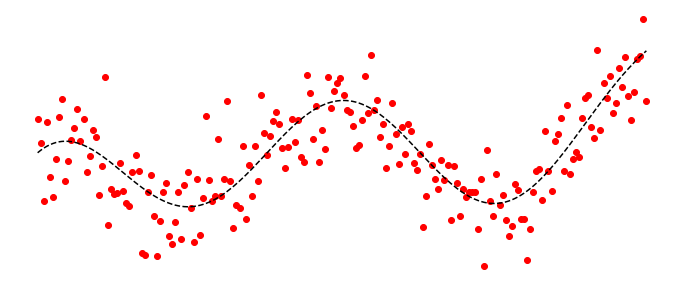

In [910]:
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

h = 0.01
var = 0.6
omega = 2*math.pi
x = torch.arange(-1,1,h).view((-1,1))
y_true = (torch.pow(x,5)+torch.cos(omega*x)).view((-1,1))
y = y_true + var*torch.randn(x.size())
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x,y,'ro')
plt.plot(x,y_true,'k--')

The red curve represent the exact funtion f, and the red points stand for the data (x, y)

## Data spliting

In [911]:
from sklearn.model_selection import train_test_split

ratio = 0.3

x_train, x_test, y_train, y_test  = train_test_split(x.numpy(), y.numpy(), test_size=ratio)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

n = x_train.shape[0]

print('Training set size :', n)

Training set size : 140


## Linear regression

We first try to learn the function f by using a linear regression.

In [912]:
from torch import nn

class LinearNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lin = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x)

In [913]:
from torch import optim
import torch.nn.functional as F

input_dim = x.shape[1]
output_dim = y.shape[1]

lr = 1e-3
bs = n
epochs = 1000

model = LinearNeuralNetwork(input_dim, output_dim)
loss_func = F.mse_loss
opt = optim.Adam(model.parameters(), lr=lr)

In [914]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch%100 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 1.0231164693832397
epoch 100 / loss = 0.9517651200294495
epoch 200 / loss = 0.9107381701469421
epoch 300 / loss = 0.8889229893684387
epoch 400 / loss = 0.8776243329048157
epoch 500 / loss = 0.8716766238212585
epoch 600 / loss = 0.868513286113739
epoch 700 / loss = 0.866879403591156
epoch 800 / loss = 0.8660871386528015
epoch 900 / loss = 0.8657320141792297


In [915]:
train_loss = loss_func(model(x_train), y_train).item()
val_loss = loss_func(model(x_test), y_test).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)

df = pd.DataFrame(index=['Training_Loss','Validation_Loss'])
df['LinearRegression'] = [train_loss, val_loss]

Training set loss = 0.8655862808227539
Test set loss = 0.6665831804275513


In [916]:
y_pred = model(x).detach().numpy()

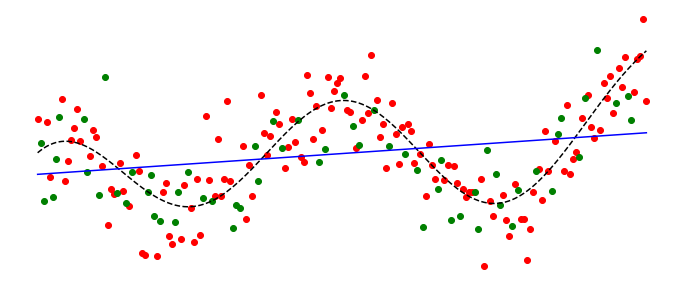

In [917]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'go')
plt.plot(x,y_true,'k--')
plt.plot(x,y_pred,'b-')
plt.show()

The red points stand for the training data, whereas the green points stand for the validation data.
The function learnt by using the linear regression is depicted in blue.

As we can see, the model is not enough complex.

## Polynomial regression

A way to adapt our linear regression to more complex functions, is by extended the input features.
Here try to learn the function f by using the following model: $$\hat{y} = \sum\limits_{d=0}^D \alpha_d x^d$$
and where the coefficients $$\alpha_d$$ will be learnt.

In [918]:
D = 8

x_train_new = torch.empty((n,D))
x_test_new = torch.empty((x_test.shape[0],D))
x_new = torch.empty((x.shape[0],D))

for d in range(D):
    x_train_new[:,d] = torch.pow(x_train.view(-1),d+1)
    x_test_new[:,d] = torch.pow(x_test.view(-1),d+1)
    x_new[:,d] = torch.pow(x.view(-1),d+1)

In [919]:
lr = 1e-1
bs = n
epochs = 10000

model_poly = LinearNeuralNetwork(D, output_dim)
loss_func = F.mse_loss
opt = optim.Adam(model_poly.parameters(), lr=lr)

In [920]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train_new[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model_poly(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch%1000 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 1.0721876621246338
epoch 1000 / loss = 0.28623875975608826
epoch 2000 / loss = 0.2853931784629822
epoch 3000 / loss = 0.28447866439819336
epoch 4000 / loss = 0.2838171124458313
epoch 5000 / loss = 0.28338900208473206
epoch 6000 / loss = 0.28315654397010803
epoch 7000 / loss = 0.28302231431007385
epoch 8000 / loss = 0.2839867174625397
epoch 9000 / loss = 0.2828840911388397


In [922]:
train_loss = loss_func(model_poly(x_train_new), y_train).item()
val_loss = loss_func(model_poly(x_test_new), y_test).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)

df['PolynomialRegression'] = [train_loss, val_loss]

Training set loss = 0.2828584909439087
Test set loss = 0.4132671654224396


In [923]:
y_pred = model_poly(x_new).detach().numpy()

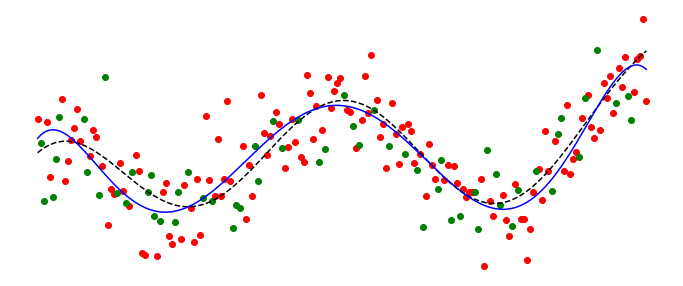

In [924]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'go')
plt.plot(x,y_true,'k--')
plt.plot(x,y_pred,'b-')
plt.show()

We get here very good result.

However, in more general case, fitting f with a polynomial will be not possible.

To handle this issue, we will use a deep neural network.

## Deep Neural Network
Consider now a deep neural network compose of three hidden layers.

In [925]:
class DeepNeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim):
        super().__init__()
        self.hidden_1 = torch.nn.Linear(input_dim, hidden_1_dim)   # hidden layer
        self.hidden_2 = torch.nn.Linear(hidden_1_dim, hidden_2_dim)   # hidden layer
        self.hidden_3 = torch.nn.Linear(hidden_2_dim, hidden_3_dim)   # hidden layer
        self.predict = torch.nn.Linear(hidden_3_dim, output_dim)   # output layer

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        return self.predict(x)
    

In [926]:
input_dim = x.shape[1]
hidden_1_dim = 100
hidden_2_dim = 100
hidden_3_dim = 100
output_dim = y.shape[1]

lr = 1e-3
bs = n
epochs = 8000

model_2 = DeepNeuralNetwork(input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim)
loss_func = F.mse_loss
opt = optim.Adam(model_2.parameters(), lr=lr)

In [927]:
loss_train = []
loss_test = []
for epoch in range(epochs):
    pred = model_2(x_train)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_train.append(loss_func(model_2(x_train), y_train).item())
    loss_test.append(loss_func(model_2(x_test), y_test).item())
    if epoch%800 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.9295193552970886
epoch 800 / loss = 0.24911649525165558
epoch 1600 / loss = 0.23727509379386902
epoch 2400 / loss = 0.22253407537937164
epoch 3200 / loss = 0.20870479941368103
epoch 4000 / loss = 0.19495263695716858
epoch 4800 / loss = 0.1852658987045288
epoch 5600 / loss = 0.18125313520431519
epoch 6400 / loss = 0.17401911318302155
epoch 7200 / loss = 0.17321109771728516


In [928]:
train_loss = loss_func(model_2(x_train), y_train).item()
val_loss = loss_func(model_2(x_test), y_test).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
df['DeepNeuralNetwork'] = [train_loss, val_loss]

Training set loss = 0.1694784164428711
Test set loss = 0.581077516078949


In [929]:
y_pred = model_2(x).detach().numpy()

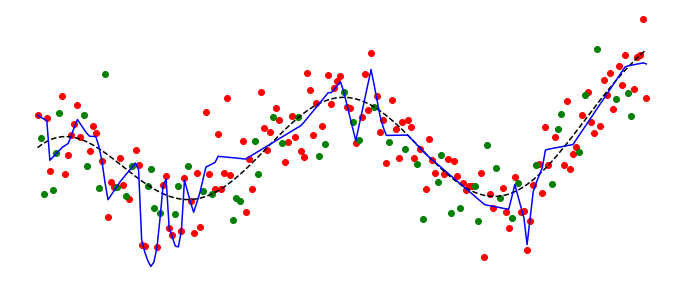

In [930]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'go')
plt.plot(x,y_true,'k--')
plt.plot(x,y_pred,'b-')
plt.show()

The deep neural network learn the additive noise.

It is shown on the graphic above, where the loss during epoch evolution in depicted for the training set (in black), and for the validation set (in red).
We can see that, if the error on the training set is decreasing, the error on the validation set is increasing.

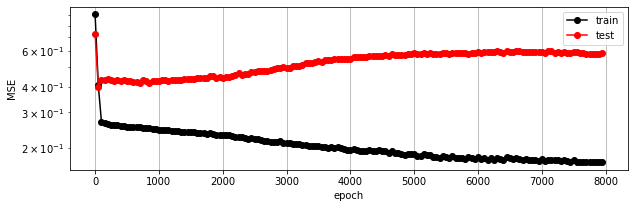

In [931]:
plt.figure(figsize=(10,3))
plt.plot(range(epochs)[::50], loss_train[::50],'ko-', label = 'train')
plt.plot(range(epochs)[::50], loss_test[::50],'ro-', label = 'test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='best')

In order to fix it, we will regularize the model by doing dropout.

## Deep Neural Network with dropout

In [932]:
class DeepNeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim):
        super().__init__()
        self.hidden_1 = torch.nn.Linear(input_dim, hidden_1_dim)   # hidden layer
        self.hidden_2 = torch.nn.Linear(hidden_1_dim, hidden_2_dim)   # hidden layer
        self.hidden_3 = torch.nn.Linear(hidden_2_dim, hidden_3_dim)   # hidden layer
        self.predict = torch.nn.Linear(hidden_3_dim, output_dim)   # output layer

    def forward(self, x, p):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.predict(x)
        return F.dropout(x, p, training=True)

In [933]:
proba = 0.1

model_2 = DeepNeuralNetwork(input_dim, hidden_1_dim, hidden_2_dim, hidden_3_dim, output_dim)
loss_func = F.mse_loss
opt = optim.Adam(model_2.parameters(), lr=lr)

In [934]:
loss_train = []
loss_test = []
for epoch in range(epochs):
    pred = model_2(x_train, proba)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_train.append(loss_func(model_2(x_train, 0), y_train).item())
    loss_test.append(loss_func(model_2(x_test, 0), y_test).item())
    if epoch%800 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.9151824116706848
epoch 800 / loss = 0.282625287771225
epoch 1600 / loss = 0.28237655758857727
epoch 2400 / loss = 0.2874039113521576
epoch 3200 / loss = 0.31564751267433167
epoch 4000 / loss = 0.2176281213760376
epoch 4800 / loss = 0.25095364451408386
epoch 5600 / loss = 0.24816450476646423
epoch 6400 / loss = 0.2951184809207916
epoch 7200 / loss = 0.2463291734457016


In [935]:
train_loss = loss_func(model_2(x_train, 0), y_train).item()
val_loss = loss_func(model_2(x_test, 0), y_test).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
df['DNN_dropout_prob=0.1'] = [train_loss, val_loss]

Training set loss = 0.18202956020832062
Test set loss = 0.4605073034763336


In [936]:
y_pred = model_2(x, 0).detach().numpy()

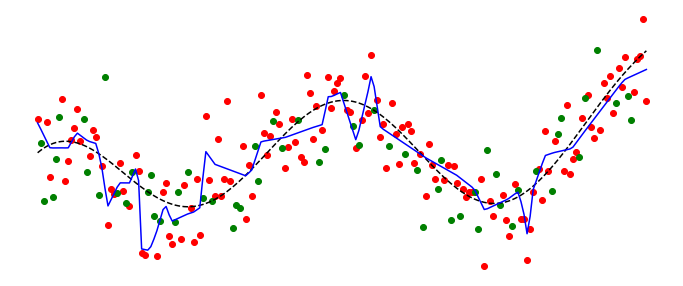

In [937]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'go')
plt.plot(x,y_true,'k--')
plt.plot(x,y_pred,'b-')
plt.show()

We have choose a lower probability for the dropout.

If the model is less overfitting than previously, the prediction is still not enough accurate

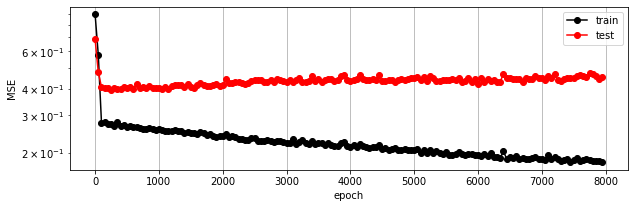

In [938]:
plt.figure(figsize=(10,3))
plt.plot(range(epochs)[::50], loss_train[::50],'ko-', label = 'train')
plt.plot(range(epochs)[::50], loss_test[::50],'ro-', label = 'test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='best')

## Increasing the dropout probability

# $$p = 0.3$$

In [939]:
proba = 0.3

loss_train = []
loss_test = []
for epoch in range(epochs):
    pred = model_2(x_train, proba)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_train.append(loss_func(model_2(x_train, 0), y_train).item())
    loss_test.append(loss_func(model_2(x_test, 0), y_test).item())
    if epoch%800 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.3881258964538574
epoch 800 / loss = 0.44155004620552063
epoch 1600 / loss = 0.3976726233959198
epoch 2400 / loss = 0.36890909075737
epoch 3200 / loss = 0.43428245186805725
epoch 4000 / loss = 0.409282386302948
epoch 4800 / loss = 0.3915787637233734
epoch 5600 / loss = 0.3901708722114563
epoch 6400 / loss = 0.3801026940345764
epoch 7200 / loss = 0.41607093811035156


In [889]:
train_loss = loss_func(model_2(x_train, 0), y_train).item()
val_loss = loss_func(model_2(x_test, 0), y_test).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
df['DNN_dropout_prob=0.3'] = [train_loss, val_loss]

Training set loss = 0.41661614179611206
Test set loss = 0.47765979170799255


In [940]:
y_pred = model_2(x, 0).detach().numpy()

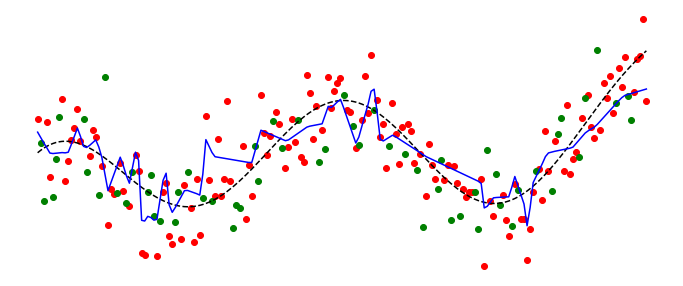

In [941]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'go')
plt.plot(x,y_true,'k--')
plt.plot(x,y_pred,'b-')
plt.show()

# $$p=0.5$$

In [942]:
proba = 0.5

loss_train = []
loss_test = []
for epoch in range(epochs):
    pred = model_2(x_train, proba)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_train.append(loss_func(model_2(x_train, 0), y_train).item())
    loss_test.append(loss_func(model_2(x_test, 0), y_test).item())
    if epoch%800 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 0.5357581973075867
epoch 800 / loss = 0.5310876965522766
epoch 1600 / loss = 0.4785628318786621
epoch 2400 / loss = 0.5827944278717041
epoch 3200 / loss = 0.5138224363327026
epoch 4000 / loss = 0.5710874199867249
epoch 4800 / loss = 0.5586671829223633
epoch 5600 / loss = 0.484314888715744
epoch 6400 / loss = 0.4860054552555084
epoch 7200 / loss = 0.5019316673278809


In [943]:
train_loss = loss_func(model_2(x_train, 0), y_train).item()
val_loss = loss_func(model_2(x_test, 0), y_test).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
df['DNN_dropout_prob=0.5'] = [train_loss, val_loss]

Training set loss = 0.3554755449295044
Test set loss = 0.47926419973373413


In [944]:
y_pred = model_2(x, 0).detach().numpy()

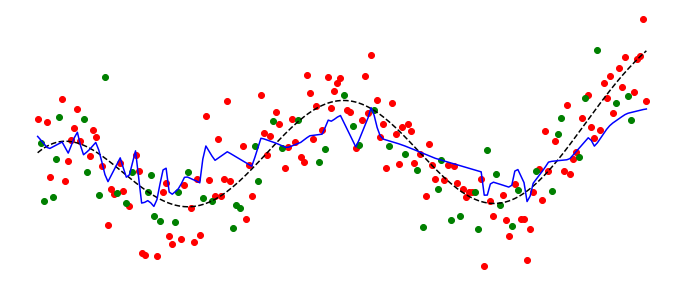

In [945]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'go')
plt.plot(x,y_true,'k--')
plt.plot(x,y_pred,'b-')
plt.show()

# $$p= 0.9$$

In [946]:
proba = 0.9

loss_train = []
loss_test = []
for epoch in range(epochs):
    pred = model_2(x_train, proba)
    loss = loss_func(pred, y_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_train.append(loss_func(model_2(x_train, 0), y_train).item())
    loss_test.append(loss_func(model_2(x_test, 0), y_test).item())
    if epoch%800 == 0:
        print('epoch', epoch, '/ loss =', loss.item())

epoch 0 / loss = 2.2923405170440674
epoch 800 / loss = 0.87214595079422
epoch 1600 / loss = 0.8145157694816589
epoch 2400 / loss = 0.8847284913063049
epoch 3200 / loss = 0.9069234132766724
epoch 4000 / loss = 0.7909652590751648
epoch 4800 / loss = 0.8595491647720337
epoch 5600 / loss = 0.8304699063301086
epoch 6400 / loss = 0.861047089099884
epoch 7200 / loss = 0.8848884701728821


In [947]:
train_loss = loss_func(model_2(x_train, 0), y_train).item()
val_loss = loss_func(model_2(x_test, 0), y_test).item()

print('Training set loss =', train_loss)
print('Test set loss =', val_loss)
df['DNN_dropout_prob=0.9'] = [train_loss, val_loss]

Training set loss = 0.7900933027267456
Test set loss = 0.6374483108520508


In [948]:
y_pred = model_2(x, 0).detach().numpy()

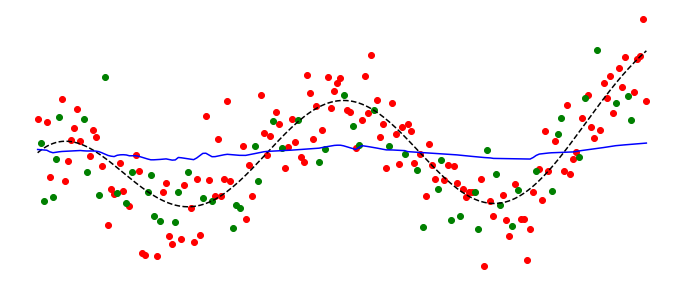

In [949]:
plt.figure(figsize=(12,5))
plt.axis('off')
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'go')
plt.plot(x,y_true,'k--')
plt.plot(x,y_pred,'b-')
plt.show()

## Summary

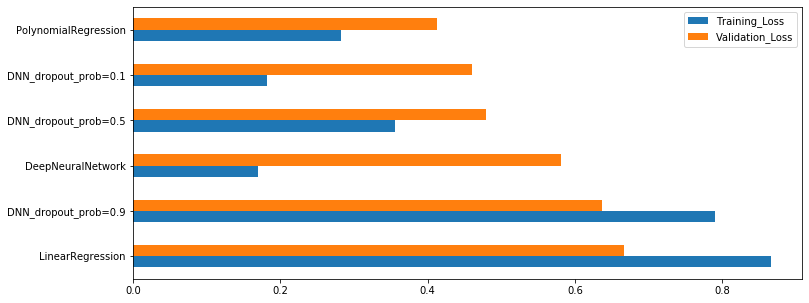

In [960]:
df.T.sort_values(by='Validation_Loss',ascending=False).plot(kind='barh',figsize=(12,5))